In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
from numpy import copy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import callbacks

In [2]:
model = keras.models.load_model("FaceMask_model")
#model.summary()

In [3]:
df_train_all = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')
#y=df_train['label']
#X = df_train.drop(['label'], axis=1)
df_train, df_valid = train_test_split(df_train_all, test_size=0.15, stratify=df_train_all['label'], random_state=1)

In [4]:
#Number of images used in the traininng after Augmentation 
df_train_all['label'].value_counts()

mask_incorrectly_worn    6135
without_mask             5925
with_mask                2158
Name: label, dtype: int64

In [5]:
#Number of images used in the traininng after validation split 
df_train['label'].value_counts()

mask_incorrectly_worn    5215
without_mask             5036
with_mask                1834
Name: label, dtype: int64

In [6]:
#Number of images used in validation 
df_valid['label'].value_counts()

mask_incorrectly_worn    920
without_mask             889
with_mask                324
Name: label, dtype: int64

In [7]:
#Test data counts
df_test['label'].value_counts()

with_mask                719
without_mask             152
mask_incorrectly_worn     30
Name: label, dtype: int64

In [8]:
#datagenTrain = ImageDataGenerator(rescale=1./255, validation_split=0.25 )
datagen = ImageDataGenerator(rescale=1./255)


trainData=datagen.flow_from_dataframe(
dataframe=df_train,
directory="./TrainTestData/",
x_col="cropped_image_file",
y_col="label",
batch_size=50,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32),
interpolation='nearest',
subset='training'
)

validData=datagen.flow_from_dataframe(
dataframe=df_valid,
directory="./TrainTestData/",
x_col="cropped_image_file",
y_col="label",
batch_size=50,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32),
interpolation='nearest',
#subset='validation'
)

testData=datagen.flow_from_dataframe(
dataframe=df_test,
directory="./TrainTestData/",
x_col="cropped_image_file",
y_col="label",
batch_size=50,
seed=42,
shuffle=False,
#class_mode="categorical",
target_size=(32,32),
interpolation='nearest')

Found 2310 validated image filenames belonging to 3 classes.
Found 403 validated image filenames belonging to 3 classes.
Found 901 validated image filenames belonging to 3 classes.


c:\python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 9775 invalid image filename(s) in x_col="cropped_image_file". These filename(s) will be ignored.
  warnings.warn(
c:\python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1730 invalid image filename(s) in x_col="cropped_image_file". These filename(s) will be ignored.
  warnings.warn(


In [9]:
epochs = [20, 30, 50, 70]
batch_size = [16, 32, 64, 100]
param_grid = dict(epochs=epochs, batch_size=batch_size)

In [10]:
earlyStopping = callbacks.EarlyStopping(monitor="val_loss",
                                       mode="min", patience=15,
                                       restore_best_weights=True)

In [11]:
history = model.fit(
        trainData,
        steps_per_epoch=trainData.n//trainData.batch_size,
        validation_data=validData,
        validation_steps=validData.n//validData.batch_size,
        epochs=70,
        callbacks=[earlyStopping]
        )
model.save_weights('try1.h5')  # 

Epoch 1/70
46/46 [==============================] - 3s 38ms/step - loss: 0.8720 - accuracy: 0.7332 - val_loss: 0.6359 - val_accuracy: 0.8050
Epoch 2/70
46/46 [==============================] - 1s 32ms/step - loss: 0.5995 - accuracy: 0.7947 - val_loss: 0.5289 - val_accuracy: 0.8050
Epoch 3/70
46/46 [==============================] - 1s 32ms/step - loss: 0.4739 - accuracy: 0.7947 - val_loss: 0.4037 - val_accuracy: 0.8050
Epoch 4/70
46/46 [==============================] - 1s 32ms/step - loss: 0.3761 - accuracy: 0.7947 - val_loss: 0.3479 - val_accuracy: 0.8050
Epoch 5/70
46/46 [==============================] - 1s 32ms/step - loss: 0.3290 - accuracy: 0.8646 - val_loss: 0.3416 - val_accuracy: 0.8575
Epoch 6/70
46/46 [==============================] - 1s 32ms/step - loss: 0.3213 - accuracy: 0.9049 - val_loss: 0.3110 - val_accuracy: 0.9250
Epoch 7/70
46/46 [==============================] - 1s 32ms/step - loss: 0.2903 - accuracy: 0.9319 - val_loss: 0.2925 - val_accuracy: 0.9275
Epoch 8/70
46

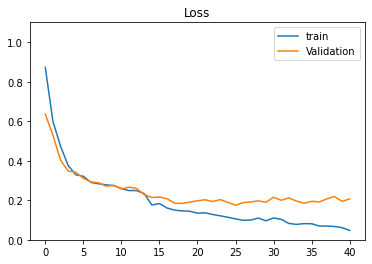

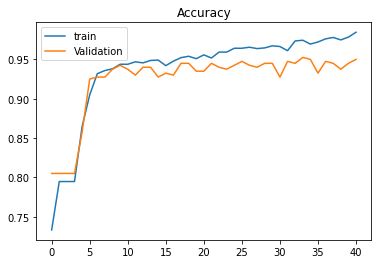

In [12]:
# evaluate the model
#_, train_acc = model.evaluate(Xtrain, ytrain, verbose=0)
#_, test_acc = model.evaluate(Xtest, ytest, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
#plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylim(0.0, 1.1)
plt.legend()
plt.show()
# plot accuracy during training
#plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='Validation')
#plt.ylim(0.0, 1.1)
plt.legend()
plt.show()

In [13]:
#Get labels map
label_map = (trainData.class_indices)
label_map

{'mask_incorrectly_worn': 0, 'with_mask': 1, 'without_mask': 2}

In [14]:
yhat_classes = model.predict(testData, verbose=0) #Gives prediction as propability
ypred = np.argmax(yhat_classes,axis=1) #Get labels from brobability
y_test_label = df_test['label'] #Read y_test
#Replace label names in y_test with the same labeling used by the model 
y_test = np.empty(len(y_test_label))
for k, v in label_map.items(): y_test[y_test_label==k] = v

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, ypred)

0.9378468368479467

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred,target_names = label_map.keys() ))

                       precision    recall  f1-score   support

mask_incorrectly_worn       0.53      0.30      0.38        30
            with_mask       0.97      0.97      0.97       719
         without_mask       0.84      0.91      0.88       152

             accuracy                           0.94       901
            macro avg       0.78      0.73      0.74       901
         weighted avg       0.93      0.94      0.93       901



In [17]:
score = model.evaluate(testData, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

19/19 [==============================] - 0s 20ms/step - loss: 0.1722 - accuracy: 0.9378
Test loss: 0.17218343913555145
Test accuracy: 0.937846839427948
